# Market Risk project

FOURREAU Mathis

GAUSSIN Natacha

ESILV IF3

# Library and dataset importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.integrate import cumulative_trapezoid as cumtrapz

In [2]:
# Load the dataset
df = pd.read_csv("Natixis.csv", sep = ";")

# Transform the date column to datetime and sort the dataframe by date
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
df.sort_values("date", inplace = True)

# Transform the value column to numeric
df["value"] = (df["value"].astype(str).str.replace(",", ".", regex=False))
df["value"] = pd.to_numeric(df["value"], errors="coerce")

# display the dataframe
df

,date,value
0,2015-01-02,5.621
1,2015-01-05,5.424
2,2015-01-06,5.329
3,2015-01-07,5.224
4,2015-01-08,5.453
...,...,...
1018,2018-12-21,4.045
1019,2018-12-24,4.010
1020,2018-12-27,3.938
1021,2018-12-28,4.088


In [3]:
# Compute the returns
df["return"] = df["value"] / df["value"].shift(1) - 1

# QUESTION : EST CE QUE LES RETURNS SONT BONS ICI CAR LES VARIATIONS DE TEMPS NE SONT PAS CONSTANTES ??

## Question A (Ex2, part of Q1 and of Q2 of TD1)

**a** – From the time series of the daily prices of the stock Natixis between January 2015 and December 2016, provided with TD1, estimate a historical VaR on price returns at a one-day horizon for a given probability level (this probability is a parameter which must be changed easily). You must base your VaR on a non-parametric distribution (biweight Kernel, that is $K$ is the derivative of the logistic function $x \mapsto \frac{15}{16}(1-x^2)^2 \mathbb{1}_{|x| \leq 1}$).

In [4]:
# Extract returns for the years prior to 2017 (2015 and 2016)
returns_2015_2016 = df[df["date"] < "2017"].dropna().loc[:, "return"]
returns_2015_2016

1     -0.035047
2     -0.017515
3     -0.019704
4      0.043836
5     -0.020723
         ...   
508   -0.008118
509    0.000744
510   -0.000186
511   -0.009481
512    0.006006
Name: return, Length: 512, dtype: float64

### First step: Estimation of the kernel density 
$$\hat{f}(x) = \frac{1}{nh}\sum_{i=1}^{n} K\left(\frac{x - X_i}{h}\right)$$ with $$K(x) = \frac{15}{16}(1-x^2)^2 \mathbb{1}_{|x| \leq 1}$$

The following functions are used to generate the kernel density for a wide range of x. This will be usefull to choose the value of h.

In [5]:
#def K(x)
def K(x):
    K_tab = []
    for i in x:
        if i <= 1 and i >= -1:
            K_tab.append((15/16) * (1 - i**2)**2)
        else:
            K_tab.append(0)
    return K_tab

# def f_hat(x, h, tab_returns)
def f_hat(x, h, tab_returns):
    return sum(K((x - tab_returns) / h)) / (len(tab_returns) * h)

# estimate 1000 times f_hat
def estimate_f_hat(tab_returns, h, nb_estimations = 1000):
    x_tab = np.linspace(min(tab_returns) - 5*h, max(tab_returns) + 5*h, nb_estimations)
    f_hat_tab = []
    for x in x_tab:
        f_hat_tab.append(f_hat(x, h, tab_returns))

    return f_hat_tab, x_tab

### Second Step : Choice of h

- Tracer Graph de la densité pour different h (voir comment la densité évolue), avoir un graphique du style de p72 dans le cours.
- Utiliser un résultat théorique pour le h optimal (papier de recherche etc)

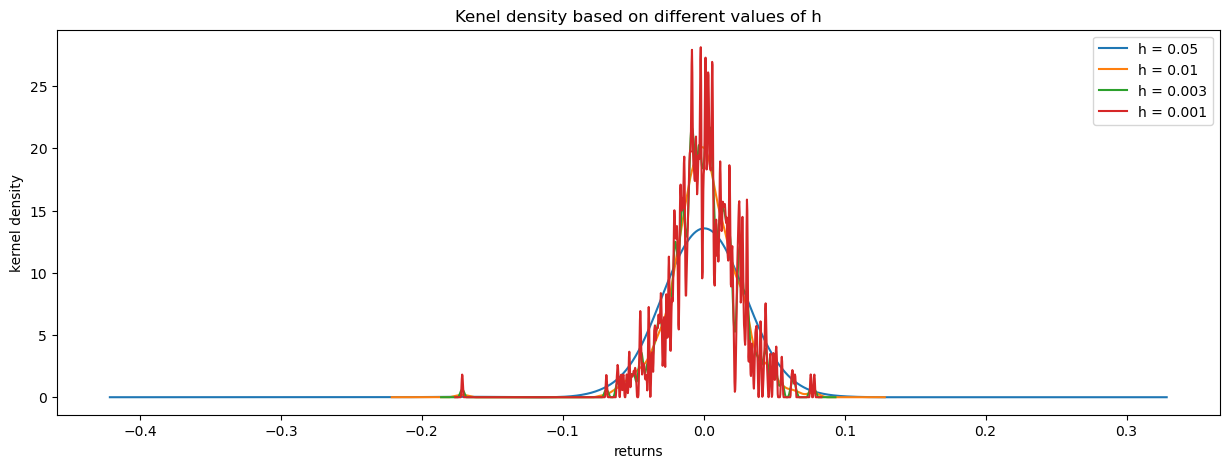

In [6]:
h_tab = [0.05, 0.01, 0.003, 0.001]

plt.figure(figsize=(15, 5))
for h in h_tab:
    f_hat_tab, x_tab = estimate_f_hat(returns_2015_2016, h)
    plt.plot(x_tab, f_hat_tab, label = f"h = {h}")

plt.xlabel("returns")
plt.ylabel("kernel density")
plt.title("Kenel density based on different values of h")
plt.legend()
plt.show()

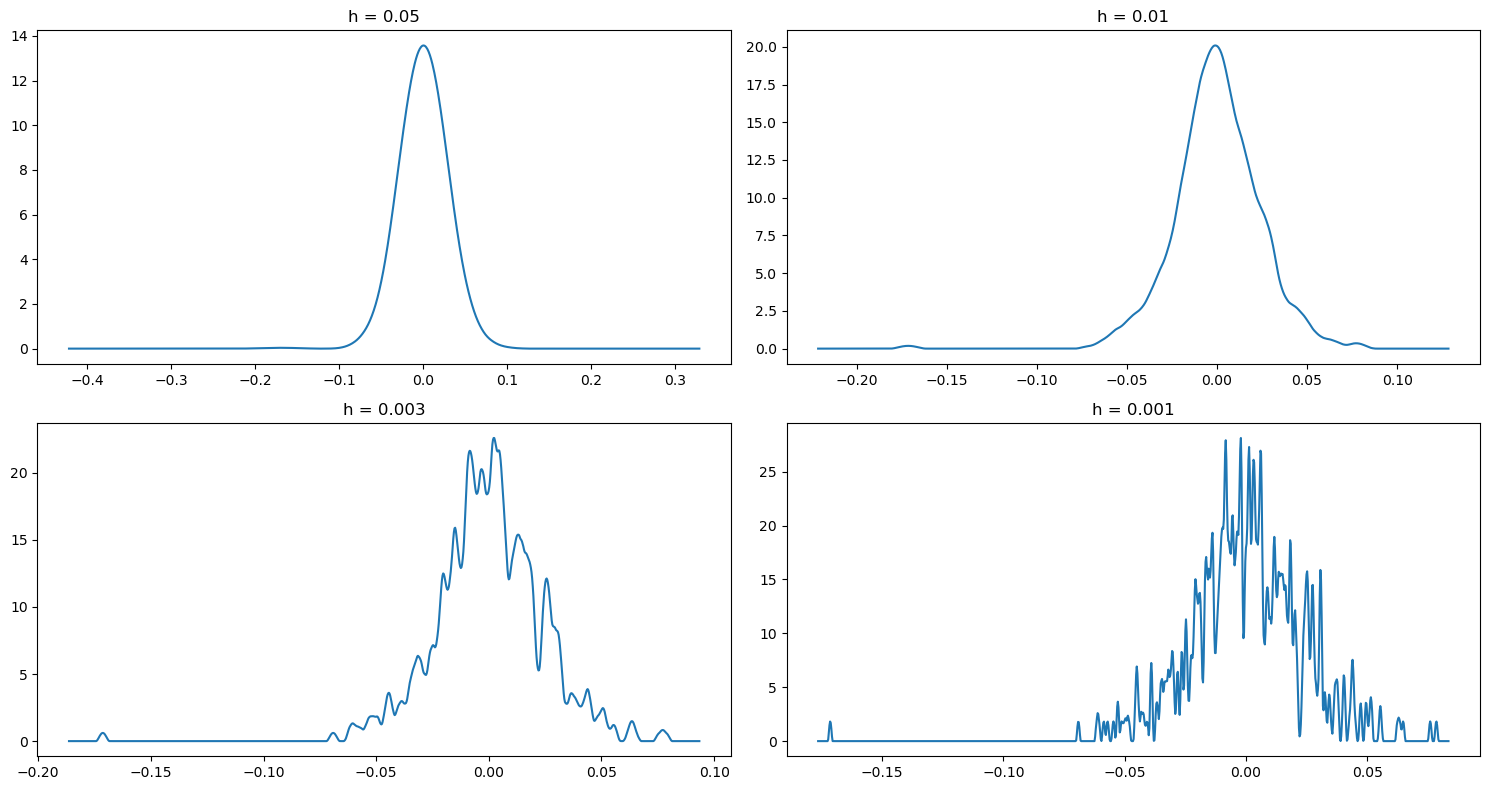

In [7]:
h_tab = [0.05, 0.01, 0.003, 0.001]
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
h = 0
for i in (0, 1):
    for j in (0, 1):
        f_hat_tab, x_tab = estimate_f_hat(returns_2015_2016, h_tab[h])
        axes[i, j].plot(x_tab, f_hat_tab)
        axes[i, j].set_title(f"h = {h_tab[h]}")
        h+=1

plt.tight_layout()
plt.show()
        

**Observations**
When h = 0.001 the density is too noisy, whereas when h = 0.01 and h = 0.05 the density is too smooth. That is why we choose h = 0.003.

### 3rd Step : Define the CDF of K and use

$$\hat{F}(x) = \frac{1}{n}\sum_{i=1}^{n} \mathcal{K}\left(\frac{x - X_i}{h}\right)$$

To define $\mathcal{K}$ we have to primitive K.

$$
\mathcal{K}(u) = \begin{cases}
0 & \text{si } u < -1 \\[0.5em]
\frac{1}{2} + \frac{15}{16}\left(u - \frac{2u^3}{3} + \frac{u^5}{5}\right) & \text{si } -1 \leq u \leq 1 \\[0.5em]
1 & \text{si } u > 1
\end{cases}
$$

In [8]:
#def K_cdf(x):
def K_cdf(x):
    if x <= 1 and x >= -1:
        return (15/16)*(x - 2*x**3/3 + x**5/5 + 8/15)
    elif x < -1:
        return 0.0
    else:
        return 1.0

def K_cdf_vector(u_tab):
    return [K_cdf(u) for u in u_tab]

def F_hat(x, h, returns_tab):
    u_tab = (x-returns_tab)/h
    return sum(K_cdf_vector(u_tab)) / len(returns_tab)

def Series_F_Hat(h, returns_tab, x_tab):
    return [F_hat(x, h, returns_tab) for x in x_tab]

def ComputeVaR(h, returns_tab, alpha, nb_estimations=1000):
    x_tab = np.linspace(min(returns_tab) - 5*h, max(returns_tab) + 5*h, nb_estimations)
    F_hat_tab = Series_F_Hat(h, returns_tab, x_tab)
    i = 0
    while i < len(F_hat_tab):
        if F_hat_tab[i] >= alpha:
            return x_tab[i]
        i+=1

    return x_tab[len(x_tab) - 1]

In [9]:
h = 0.003
alpha = 0.01
VaR = ComputeVaR(h, returns_2015_2016, alpha)
print("The historical Value at Risk base on a non-parametric distribution for level alpha,", alpha, " is equal to ", VaR)

The historical Value at Risk base on a non-parametric distribution for level alpha, 0.01  is equal to  -0.05750841439123988


**b – Which proportion of price returns between January 2017 and December 2018 does exceed the VaR
threshold defined in the previous question? Do you validate the choice of this non-parametric VaR?**


In [10]:
returns_2017_2018 = df[df["date"] >= "2017"].dropna().loc[:, "return"]
returns_2017_2018

513     0.007463
514     0.040741
515     0.003737
516    -0.008155
517    -0.005719
          ...   
1018   -0.001481
1019   -0.008653
1020   -0.017955
1021    0.038090
1022    0.007583
Name: return, Length: 510, dtype: float64

Simply find the proportion of returns < to the VaR find and compare with the alpha. Mentionne the word coverage.

In [11]:
def Proportion(df, VaR):
    return df[df < VaR].count() / df.count()

prop = Proportion(returns_2017_2018, VaR)

print("the proportion of returns that exceed the VaR threshold is", prop)

if prop > alpha:
    print("VaR underestimates the risk")
elif prop == alpha:
    print("VaR is correct")
else:
    print("VaR overestimates the risk")

the proportion of returns that exceed the VaR threshold is 0.00196078431372549
VaR overestimates the risk


## Question B (Ex2, Q5 of TD2)

**Calculate the expected shortfall for the VaR calculated in question A. How is the result, compared to the VaR?**

In [12]:
def expectedShortfall(returns_tab, VaR):
    return np.mean([l for l in returns_tab if l <= VaR])

ES_alpha = expectedShortfall(returns_2015_2016, VaR)

print("The expected shortfall is ", ES_alpha)

The expected shortfall is  -0.08422676461030879


## Question C (Ex2, Q1 and Q2 of TD3)

With the dataset provided for TD1 on Natixis prices, first calculate daily returns. You will then analyse
these returns using a specific method in the field of the EVT.

**a – Estimate the GEV parameters for the two tails of the distribution of returns, using the estimator of
Pickands. What can you conclude about the nature of the extreme gains and losses?**


In [13]:
def pickandsEstimator(returns_tab):
    returns_tab.sort()
    N = len(returns_tab)
    k = np.floor(np.log(N))
    # starts from 0 so n is :
    n = N - 1 
    e = np.log((returns_tab[int(n - k + 1)] - returns_tab[int(n - 2 * k + 1)]) / (returns_tab[int(n - 2 * k + 1)] - returns_tab[int(n - 4 * k + 1)]))
    e /= np.log(2)
    return e

def naturePickands(e):
    if e > 0:
        print("Heavy tails : GEV is of Fréchet kind")
    elif e == 0:
        print("Light tails : GEV is of Gumbel kind")
    else:
        print("Bounded support : GEV is of Weibull kind")

# loss
loss = list(df[df["return"] < 0]["return"] * -1)
e_loss = pickandsEstimator(loss)
print("e_loss :", e_loss)
naturePickands(e_loss)

# gain
gain = list(df[df["return"] > 0]["return"])
e_gain = pickandsEstimator(gain)
print("e_gain :", e_gain)
naturePickands(e_gain)

e_loss : -0.5089715779341932
Bounded support : GEV is of Weibull kind
e_gain : 0.5772338569463368
Heavy tails : GEV is of Fréchet kind


**b – Calculate the value at risk based on EVT for various confidence levels, with the assumption of iid
returns.**


**Formule du cours**

$$VaR(p) = \frac{\left(\frac{k}{n(1-p)}\right)^{\xi^P} - 1}{1 - 2^{-\xi^P}} \left(X_{n-k+1:n} - X_{n-2k+1:n}\right) + X_{n-k+1:n}$$

p is the probability to be above the VaR (so alpha = 0.99 -> p = 0.05)

In [14]:
def ComputeVaRp(returns_tab, e, p):
    returns_tab.sort()
    N = len(returns_tab)
    k = np.floor(np.log(N))
    # starts from 0 so n is :
    n = N - 1 

    multi = (k * (n * (1.0 - p))) ** e - 1.0
    multi /= (1.0 - 2.0**(-e))

    return multi * (returns_tab[int(n - k + 1)] - returns_tab[int(n - 2 * k + 1)]) + returns_tab[int(n - k + 1)]

p_tab = [ 0.95, 0.98, 0.99, 0.995]
for p in p_tab:
    print(f"for p = {p} and the estimator = {round(e_loss, 4)} we have VaR(p) = {round(ComputeVaRp(loss, e_loss, p), 4)}")

for p = 0.95 and the estimator = -0.509 we have VaR(p) = 0.0712
for p = 0.98 and the estimator = -0.509 we have VaR(p) = 0.0706
for p = 0.99 and the estimator = -0.509 we have VaR(p) = 0.0699
for p = 0.995 and the estimator = -0.509 we have VaR(p) = 0.0689


Il faudra bien voir si la VaR trouvé reste cohérente pour voir qi nos Epsilon estimés le sont aussi. C'est le epsilon loss qui nous intéresse dans cette partie. 

**Question D (Ex2, Q5 of TD4)**

With the dataset and the framework provided for TD4, estimate all the parameters of Bouchaud's price
impact model. Comment the obtained values. Is this model well specified?

In [15]:
df_TD4 = pd.read_excel("Dataset TD4.xlsx")

**Backward definition of the price: the price is the sum of past impacts (Bouchaud):**

$$p_t = p_{-\infty} + \sum_{s=-\infty}^{t-1} G(t-s)\varepsilon_s S_s V_s^r$$

where:

- $S$ is the bid-ask spread;

- $\varepsilon$ is -1 or 1 depending on whether the transaction is a buy (price = ask) or a sell (price = bid) on the market;

- $V$ is the volume of the transaction, with $r$ close to zero to have a concave function of the volume;

- $G$ is a function worth 0 on $\mathbb{R}^-$, which can be interpreted as the impact of a single order. A statistical study on long-term correlation can allow this function to be fixed, in the form, for example, of a decreasing power function.